# Práctica 4: Entrenamiento de redes neuronales

En primer lugar, hemos cargado los archivos proporcionados: por un lado, los datos de entrenamiento con imágenes de números escritos a mano (data), y por otro, los parámetros de la red neuronal (weights) que utilizaremos en las primeras pruebas. 

In [1]:
import random
import numpy as np
import scipy.optimize as opt
from scipy.io import loadmat
import matplotlib.pyplot as plt

import displayData as dd
import checkNNGradients as nn

In [2]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')
X, y = data['X'], data['y']
theta1, theta2 = weights['Theta1'], weights['Theta2']

El número de entradas de la red neuronal se corresponde con el número de píxels de cada imagen; siendo estas de 20 x 20, hacen un total de 400 elementos en la capa de entrada. La capa de salida cuenta con 10 elementos, ya que es la cantidad de etiquetas (números del 1 al 10) que vamos a clasificar. Además, nuestra red neuronal cuenta con una capa oculta de 25 elementos.

In [3]:
Lambda = 1.0
m = X.shape[0]
num_entradas = 400
num_ocultas = 25
num_etiquetas = 10

Para comprobar que hemos cargado los archivos correctamente, imprimimos una selección de 100 elementos escogidos aleatoriamente.

In [4]:
def show_selection(X):
    sel = np.random.permutation(m)
    sel = sel[:100]
    dd.displayData(X[sel, :])
    plt.show()

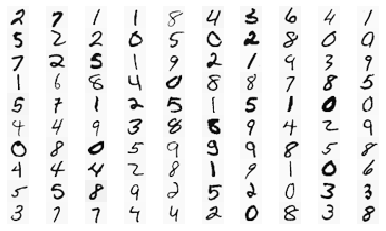

In [5]:
show_selection(X)

Esta función toma un vector y lo transforma en una matriz de tantas columnas como etiquetas haya. Cada columna representa una etiqueta, por lo que, en nuestro caso, la columna 0 tendrá todos sus elementos a 0 excepto aquellos que fuesen 10 en el vector original; la columna 1 tendrá todos sus elementos a 0 excepto aquellos que fuesen 1 en el vector original; y así sucesivamente. 

In [6]:
def convert_y(y, num_etiquetas):
    Y = np.empty((num_etiquetas, y.shape[0]), dtype=bool)
    for i in range(num_etiquetas):
        Y[i, :] = ((y[:, 0] + num_etiquetas - 1) % num_etiquetas == i)    
    Y = Y * 1
    return Y.T

In [7]:
Y = convert_y(y, num_etiquetas)
print(Y.shape)

(5000, 10)


## 1. Función de coste

Para calcular el coste de una red neuronal, utilizaremos dos funciones auxiliares. La función sigmoid(Z) devuelve el sigmoide de un elemento Z, mientras que la función feed_forward(X, theta1, theta2) lleva a cabo la propagación hacia delante de una red neuronal, devolviendo el resultado final, así como todos los estados intermedios.

In [10]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def feed_forward(X, theta1, theta2):
    a1 = np.hstack([np.ones([X.shape[0], 1]), X])
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([X.shape[0], 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    a3 = sigmoid(z3)
    return a1, z2, a2, z3, a3

### 1.1 Retro-propagación

Utilizando esta implementación vectorizada de la fórmula de coste de una red neuronal obtenemos un valor de J idéntico al esperado.

In [11]:
# Forward propogation (feed forward)
A1, Z2, A2, Z3, A3 = feed_forward(X, theta1, theta2)

# Cost function (without reg term)
cost_unreg_term = (-Y * np.log(A3) - (1 - Y) * np.log(1 - A3)).sum() / m
print(cost_unreg_term)

0.2876291651613189


### 1.2 Coste regularizado

De nuevo, utilizando esta implementación de la fórmula de coste con término de regularización (recordemos que Lambda = 1.0) obtenemos un valor de J idéntico al esperado:

In [12]:
# Cost function (with reg term)
cost_reg_term = (Lambda / (2 * m)) * (np.sum(theta1[:, 1:] ** 2) + np.sum(theta2[:, 1:] ** 2))
cost = cost_unreg_term + cost_reg_term
print(cost)

0.38376985909092365


## 2. Cálculo del gradiente

Para el cálculo del gradiente vamos a necesitar, además de los resultados de la propagación hacia delante obtenidos anteriormente, una nueva función sigmoid_derivative(Z), que nos devuelva la derivada del sigmoide de Z; esta operación es imprescindible para calcular las matrices de gradiente de la red neuronal.

In [13]:
def sigmoid_derivative(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

### 2.1 Retro-propagación

Obtendremos, como resultado, una matriz de gradientes asociada a cada uno de los parámetros de la red neuronal (theta1 y theta2). Sus dimensiones dan cuenta del paso de la capa de entrada (400 + 1) a la capa oculta (25 + 1) y de ahí a la de salida (10).

In [16]:
# Numerical gradient (without reg term)
Theta1_grad = np.zeros(np.shape(theta1))
Theta2_grad = np.zeros(np.shape(theta2))

D3 = A3 - Y
D2 = np.dot(D3, theta2)
D2 = D2 * (np.hstack([np.ones([Z2.shape[0], 1]), sigmoid_derivative(Z2)]))
D2 = D2[:, 1:]

Theta1_grad = Theta1_grad + np.dot(A1.T, D2).T
Theta2_grad = Theta2_grad + np.dot(A2.T, D3).T

print(Theta1_grad.shape)
print(Theta2_grad.shape)

(25, 401)
(10, 26)


### 2.2 Gradiente regularizado

Una vez calculadas las matrices de gradiente de cada parámetro, podemos aplicar esta implementación de la fórmula del gradiente regularizado para obtener las matrices de gradiente regularizadas.

In [18]:
# Numerical gradient (with reg term)
Theta1_grad = Theta1_grad * (1 / m)
Theta2_grad = Theta2_grad * (1 / m)
Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (Lambda / m) * theta1[:, 1:]
Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (Lambda / m) * theta2[:, 1:]
grad = np.concatenate((np.ravel(Theta1_grad), np.ravel(Theta2_grad)))
print(grad)

[ 1.23742553e-08 -2.11290576e-12  4.38917135e-13 ... -4.95497473e-05
  2.55917892e-04 -2.65402519e-04]


Aunando todo el código anterior en la función back_propagation() completamos la implementación de nuestra red neuronal de tres capas. Esta función devuelve una tupla con el coste regularizado y un vector que representa el gradiente regularizado, agrupando los valores de las dos matrices de gradiente. 

In [19]:
def back_propagation(params_rn, num_entradas, num_ocultas, num_etiquetas, X, Y, Lambda):
    # Unroll thetas (neural network params)
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))

    # Forward propogation (feed forward)
    A1, Z2, A2, Z3, A3 = feed_forward(X, theta1, theta2)

    # Cost function (without reg term)
    cost_unreg_term = (-Y * np.log(A3) - (1 - Y) * np.log(1 - A3)).sum() / m

    # Cost function (with reg term)
    cost_reg_term = (Lambda / (2 * m)) * (np.sum(theta1[:, 1:] ** 2) + np.sum(theta2[:, 1:] ** 2))
    cost = cost_unreg_term + cost_reg_term

    # Numerical gradient (without reg term)
    Theta1_grad = np.zeros(np.shape(theta1))
    Theta2_grad = np.zeros(np.shape(theta2))
    D3 = A3 - Y
    D2 = np.dot(D3, theta2)
    D2 = D2 * (np.hstack([np.ones([Z2.shape[0], 1]), sigmoid_derivative(Z2)]))
    D2 = D2[:, 1:]
    Theta1_grad = Theta1_grad + np.dot(A1.T, D2).T
    Theta2_grad = Theta2_grad + np.dot(A2.T, D3).T

    # Numerical gradient (with reg term)
    Theta1_grad = Theta1_grad * (1 / m)
    Theta2_grad = Theta2_grad * (1 / m)
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (Lambda / m) * theta1[:, 1:]
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (Lambda / m) * theta2[:, 1:]
    grad = np.concatenate((np.ravel(Theta1_grad), np.ravel(Theta2_grad)))

    return (cost, grad)

## 3. Aprendizaje de los parámetros

Hemos implementado una función que inicializa los pesos de la red neuronal en base a un parámetro epsilon, de modo que ya no será necesario utilizar los pesos del archivo ex4weights.mat; del mismo modo, hemos implementado una función para obtener los valores óptimos de theta y una función para medir el nivel de precisión de clasificación de nuestra red neuronal.

In [32]:
def randomize_weights(L_in, L_out, Epsilon):
    return np.random.uniform(-Epsilon, Epsilon, (L_out, 1 + L_in))

In [36]:
def optimize(backprop, params_rn, input_layer_size, hidden_layer_size, num_labels, X, Y, Lambda, num_iter):
    result = opt.minimize(fun=backprop, x0=params_rn,
    args=(input_layer_size, hidden_layer_size, num_labels, X, Y, Lambda),
    method='TNC', jac=True, options={'maxiter': num_iter})
    return result.x

In [37]:
def check_accuracy(y, out):
    max_i = np.argmax(out, axis = 1) + 1
    control = (y[:, 0] == max_i) 
    return 100 * np.size(np.where(control == True)) / y.shape[0]

Utilizando unos valores de epsilon=0.12, Lambda=1.0 y num_iters=70, el porcentaje de precisión de nuestra red neuronal es superior al 93%, dentro de los esperado; en otras pruebas realizadas se han conseguido valores en torno al rango 92-94%. 

Además, hemos comprobado la precisión de nuestros cálculos de gradiente comparándolos con los de la función checkNNGradients() incluida en el material de la práctica. Las diferencias que obtenemos son del orden de -14, cuando el mínimo aceptable es por debajo de -9, por lo que concluimos que el cálculo es extremadamente preciso.

In [38]:
# Init Neural Network params
theta1 = randomize_weights(theta1.shape[1] - 1, theta1.shape[0], 0.12)
theta2 = randomize_weights(theta2.shape[1] - 1, theta2.shape[0], 0.12)

# Train Neural Network
params_rn = np.concatenate([theta1.reshape(-1), theta2.reshape(-1)])
theta_opt = optimize(back_propagation, params_rn, num_entradas, num_ocultas, num_etiquetas, X, Y, Lambda, 70)
theta1_opt = np.reshape(theta_opt[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
theta2_opt = np.reshape(theta_opt[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1 )))

# Check Results
percentage = check_accuracy(y, feed_forward(X, theta1_opt, theta2_opt)[4])
print("Neural network success rate: {}%".format(percentage))
print(nn.checkNNGradients(back_propagation, Lambda))


Neural network success rate: 93.3%
[ 5.37822553e-14  9.23550516e-16  6.64412644e-15  7.39169061e-15
 -5.92474745e-14  3.53219515e-15 -1.04914992e-14 -4.53506183e-14
 -9.31204170e-14  9.98371308e-15 -4.15395528e-14 -1.28118382e-13
 -2.30518594e-14  6.16057227e-15 -7.91126062e-15 -2.07295390e-14
  2.44186046e-14 -1.61120574e-15  8.66718332e-15  2.93872728e-14
  6.26485354e-14  1.59143261e-14  7.17026265e-15  4.78973415e-15
  1.52137011e-14  1.56697572e-14  6.80993077e-14  1.74331036e-14
  7.20549922e-15  1.00804510e-14  1.95364287e-14  1.84144150e-14
  7.34130638e-14  1.43619925e-14  5.23759096e-15  1.78738046e-14
  1.97075158e-14  1.94462231e-14]


Para agilizar la comprobación de resultados con otros parámetros de aprendizaje, hemos aunado el código anterior en una función neural_network_training() que recibe como argumentos todos los parámetros de configuración y aprendizaje posibles, de cara a futuras pruebas con otros valores de Lambda, Epsilon y num_iters.

In [39]:
def neural_network_training(theta1, theta2, input_layer_size, hidden_layer_size, num_labels, X, Y, Epsilon, Lambda, num_iter):
    # Init Neural Network params
    theta1 = randomize_weights(theta1.shape[1] - 1, theta1.shape[0], Epsilon)
    theta2 = randomize_weights(theta2.shape[1] - 1, theta2.shape[0], Epsilon)

    # Train Neural Network
    params_rn = np.concatenate([theta1.reshape(-1), theta2.reshape(-1)])
    theta_opt = optimize(back_propagation, params_rn, input_layer_size, hidden_layer_size, num_labels, X, Y, Lambda, num_iter)
    theta1_opt = np.reshape(theta_opt[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))
    theta2_opt = np.reshape(theta_opt[hidden_layer_size * (input_layer_size + 1):], (num_labels, (hidden_layer_size + 1 )))

    return check_accuracy(y, feed_forward(X, theta1_opt, theta2_opt)[4])

In [40]:
Epsilon = 0.12
Lambda = 1.0
num_iter = 70

percentage = neural_network_training(theta1, theta2, num_entradas, num_ocultas, num_etiquetas, X, Y, Epsilon, Lambda, num_iter)
print("Neural Network (Lambda:{}, Iters:{}) success rate: {}%".format(Lambda, num_iter, percentage))

Neural Network (Lambda:1.0, Iters:70) success rate: 94.18%
